SIFT - Scale-Invariant Feature Transform - Part 3
============================

In the last notebook we took our gaussian blurred images and created difference of gaussian (DoG) representations
from the different blur levels.  In this notebook we will be taking the generated DoG results and extracting keypoints
that will be used for feature generation in the next slide.  

In [85]:
# Common Libraries to load
import os
import cv2

import numpy as np
import itertools as it

from PIL import Image
from dataclasses import dataclass
from typing import List

from modeling.image.sift import octave_creator, convert_octave_opencv_levels_to_pillow, difference_of_gaussian

The first thing we are going to do is get our notebook back into the state from the previous notebook, basically
so we have our DoG results.  

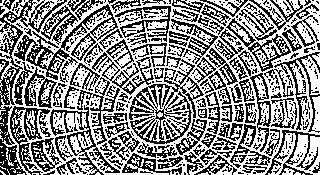

In [87]:
#IMAGE_PATH = os.path.join(os.getcwd(), '..', 'raw_data', 'star_wars', 'star-wars-saber.jpg')
IMAGE_PATH = os.path.join(os.getcwd(), '..', 'raw_data', 'gaussian', 'gaussian_blur_example.png')
#IMAGE_PATH = os.path.join(os.getcwd(), '..', 'raw_data', 'random_images', 'dog', 'dog_06.jpg')

original_image = Image.open(IMAGE_PATH)
bw_image = original_image.convert('L')
bw_octaves = octave_creator(bw_image, up_samples=None)
bw_dogs = difference_of_gaussian(bw_octaves)
display(convert_octave_opencv_levels_to_pillow(bw_dogs)[0][0])

## Finding Maxima/Minima

The first thing we are going to want to do is to find the local maxima and minima in the DoG results.  This is accomplished
easily by taking a single point and its 26 nearest neighbors with the following breakdown.  

1. 9 neighbors from the same point in the layer above the current layer
2. 8 directly adjacent members from current layer
3. 9 neighbors from the same point in the layer below the current layer

In this case you will only consider the selected point to be a minimum or maximum if it is smaller than or greater than
all the other neighbors.  

**NOTE:** Since this requires a layer to be both above and below, this means that the first and last layers are not even
checked, it also means that we will always have 2 less outputs then the DoG levels calculated against.  So in the case of
4 DoG layers (created from 5 blur levels) we will have only 2 maxima/minima outputs.  

In [88]:
def maxima_minima_of_layer(upper_layer, check_layer, lower_layer):
    height = len(check_layer)
    width = len(check_layer[0])
    
    def get_layer_values(layer, x, y, include_point=True):
        return [
            layer[y_i][x_i] for y_i in range(-1, 2) for x_i in range(-1, 2) if x_i != 0 and y_i != 0 and not include_point 
        ]
    
    minimas = []
    maximas = []
    for y in range(1, height-1):
        for x in range(1, width-1):
            upper_layer_values = get_layer_values(upper_layer, x, y)
            lower_layer_values = get_layer_values(lower_layer, x, y)
            current_layer_values = get_layer_values(check_layer, x, y, include_point=False)
            point_value = check_layer[y][x]
            
            is_minima = True
            is_maxima = True
            for n in it.chain(upper_layer_values, lower_layer_values, current_layer_values):
                if n <= point_value:
                    is_minima = False
                
                if n >= point_value:
                    is_maxima = False
                    
                if not is_maxima and not is_minima:
                    break
                    
            if is_minima:
                minimas.append((x, y, point_value))
            if is_maxima:
                maximas.append((x, y, point_value))
                
    return minimas, maximas

In [89]:
octave_index = 0
layer_index = 2

minimas, maximas = maxima_minima_of_layer(bw_dogs[octave_index][layer_index-1], 
                                          bw_dogs[octave_index][layer_index], 
                                          bw_dogs[octave_index][layer_index+1])

print(f'minimas: {len(minimas)}, maximas: {len(maximas)}')

minimas: 0, maximas: 17567


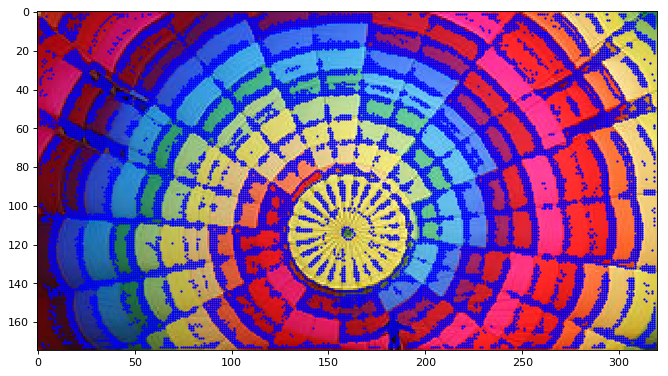

In [92]:
## Maxima
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

implot = plt.imshow(original_image)

maxima_x = [m[0] for m in maximas]
maxima_y = [m[1] for m in maximas]

plt.scatter(x=maxima_x, y=maxima_y, c='b', s=1)

plt.show()

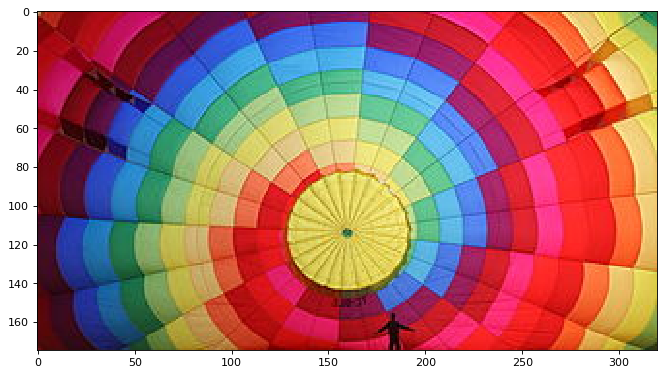

In [91]:
## Minima
import matplotlib.pyplot as plt

fig = plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
implot = plt.imshow(original_image)

minima_x = [m[0] for m in minimas]
minima_y = [m[1] for m in minimas]

plt.scatter(x=minima_x, y=minima_y, c='b', s=1)

plt.show()

## References

* [AI Shack - SIFT](http://aishack.in/tutorials/sift-scale-invariant-feature-transform-scale-space/)
* [(Whitepaper) - Distinctive Image Features from Scale-Invariant Keypoints](http://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf) 